# 보스턴 집값 예측

[사용 데이터]
- 보스턴 집값 데이터

[분석 목적]
- 1. 시각화 : 보스턴 집값 데이터를 보고, 어떠한 상황이 많은지, 시각화를 통해서 데이터를 탐색적으로 분석해봄
- 2. 머신러닝 : 주어진 데이터를 토대로, 머신러닝 모델을 만들어 봄으로써, 보스턴 집값이 어떻게 변화되는지 과정들을 확인함
[진행 과정]
1. 데이터셋 확인 - 대부분의 캐글 데이터들은 잘 정제되어 있습니다. 하지만 가끔 null data가 존재합니다. 이를 확인하고, 향후 수정합니다.
2. 탐색적 데이터 분석(exploratory data analysis) - 여러 feature 들을 개별적으로 분석하고, feature 들 간의 상관관계를 확인합니다. 여러 시각화 툴을 사용하여 insight를 얻습니다.
3. feature engineering - 모델을 세우기에 앞서, 모델의 성능을 높일 수 있도록 feature 들을 engineering 합니다. one-hot encoding, class로 나누기, 구간으로 나누기, 텍스트 데이터 처리 등을 합니다.
4. model 만들기 - sklearn 을 사용해 모델을 만듭니다. 파이썬에서 머신러닝을 할 때는 sklearn 을 사용하면 수많은 알고리즘을 일관된 문법으로 사용할 수 있습니다. 물론 딥러닝을 위해 tensorflow, pytorch 등을 사용할 수 도 있습니다.
5. 모델 학습 및 예측 - trainset 을 가지고 모델을 학습시킨 후, testset 을 가지고 prediction 합니다.
6. 모델 평가 - 예측 성능이 원하는 수준인지 판단합니다. 풀려는 문제에 따라 모델을 평가하는 방식도 달라집니다. 학습된 모델이 어떤 것을 학습하였는 지 확인해봅니다.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats  # 과학용 계산 라이브러리
from sklearn.datasets import load_boston  # 사이킷런 데이타셋
%matplotlib inline
import warnings
warnings.filterwarnings('ignore') # 경고무시

In [13]:
# boston 데이타셋 로드
boston = load_boston()

# boston 데이타셋 DataFrame 변환
df = pd.DataFrame(boston.data, columns = boston.feature_names)

# target array로 주택가격(price)을 추가함.
df['PRICE'] = boston.target
print('Boston 데이타셋 크기 :', df.shape)
df.head(2)

Boston 데이타셋 크기 : (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.9,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.9,9.14,21.6


### 칼럼 정의
- CRIM: 지역별 범죄 발생률
- ZN: 25,000평방피트를 초과하는 거주 지역의 비율
- NDUS: 비상업 지역 넓이 비율
- CHAS: 찰스강에 대한 더미 변수(강의 경계에 위치한 경우는 1, 아니면 0)
- NOX: 일산화질소 농도
- RM: 거주할 수 있는 방 개수
- AGE: 1940년 이전에 건축된 소유 주택의 비율
- DIS: 5개 주요 고용센터까지의 가중 거리
- RAD: 고속도로 접근 용이도
- TAX: 10,000달러당 재산세율
- PTRATIO: 지역의 교사와 학생 수 비율
- B: 지역의 흑인 거주 비율
- LSTAT: 하위 계층의 비율
- PRICE: 본인 소유의 주택 가격(중앙값) - 종속변수 (위의 건 독립변수)

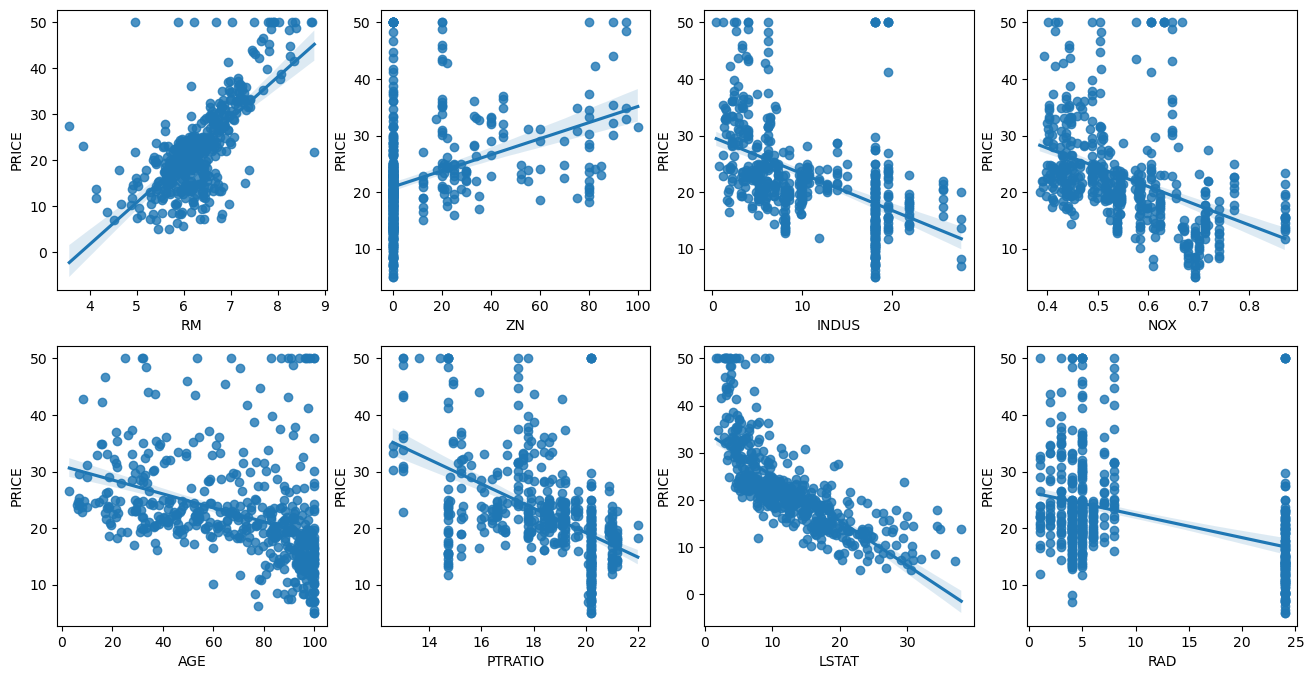

In [14]:
# 각 칼럼별 상관관계 파악
# 2x4 subplot 이용. axs는 4x2
fig, axs = plt.subplots(figsize=(16,8), ncols=4, nrows=2)

lm_features = ['RM','ZN','INDUS','NOX','AGE','PTRATIO','LSTAT','RAD']

# i에는 인덱스가 feature에는 RM ~ RAD까지 순차적으로 들어감
for i, feature in enumerate(lm_features):
    row = int(i/4) # 2행
    col = i%4

    # sns.regplot : 회귀직선을 그려줌
    sns.regplot(x=feature, y='PRICE', data=df, ax=axs[row][col])

- 해당 내용을 확인하면, RM(방 개수)는 확실하게 집값 상승과 상관관계가 있다고 파악할 수 있고, LSTAT(하위계층 비율)은 집값하락과 상관관계가 있다고 할 수 있습니다.

- 정확한 집값과의 상관관계는 다음과 같습니다

In [21]:
df.corr()['PRICE']

CRIM      -0.388305
ZN         0.360445
INDUS     -0.483725
CHAS       0.175260
NOX       -0.427321
RM         0.695360
AGE       -0.376955
DIS        0.249929
RAD       -0.381626
TAX       -0.468536
PTRATIO   -0.507787
B          0.333461
LSTAT     -0.737663
PRICE      1.000000
Name: PRICE, dtype: float64

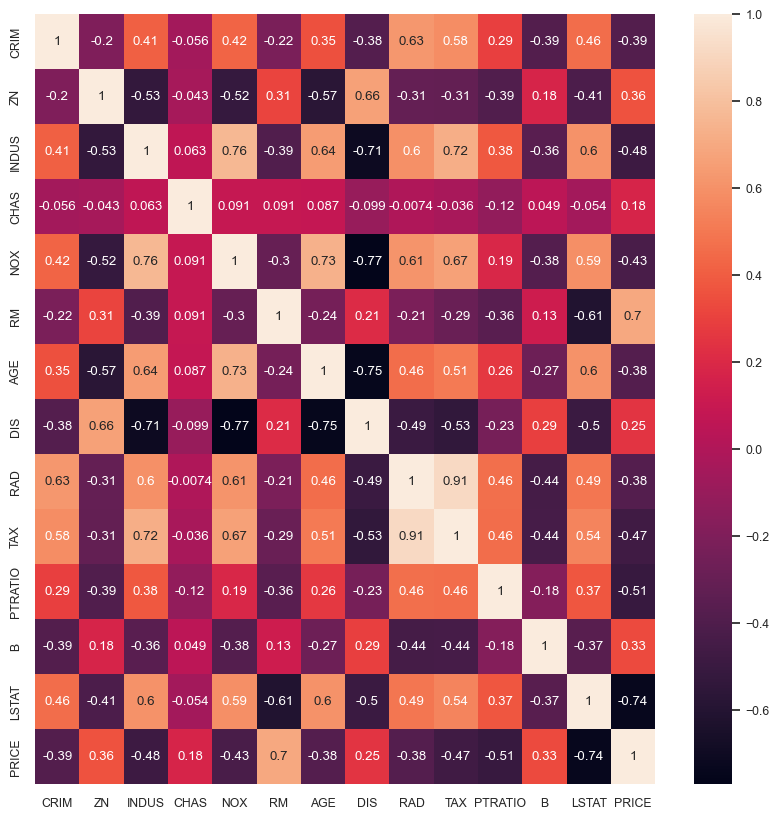

In [28]:
# 전체 상관관계 확인
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True)
sns.set(font_scale=0.8)
plt.show()

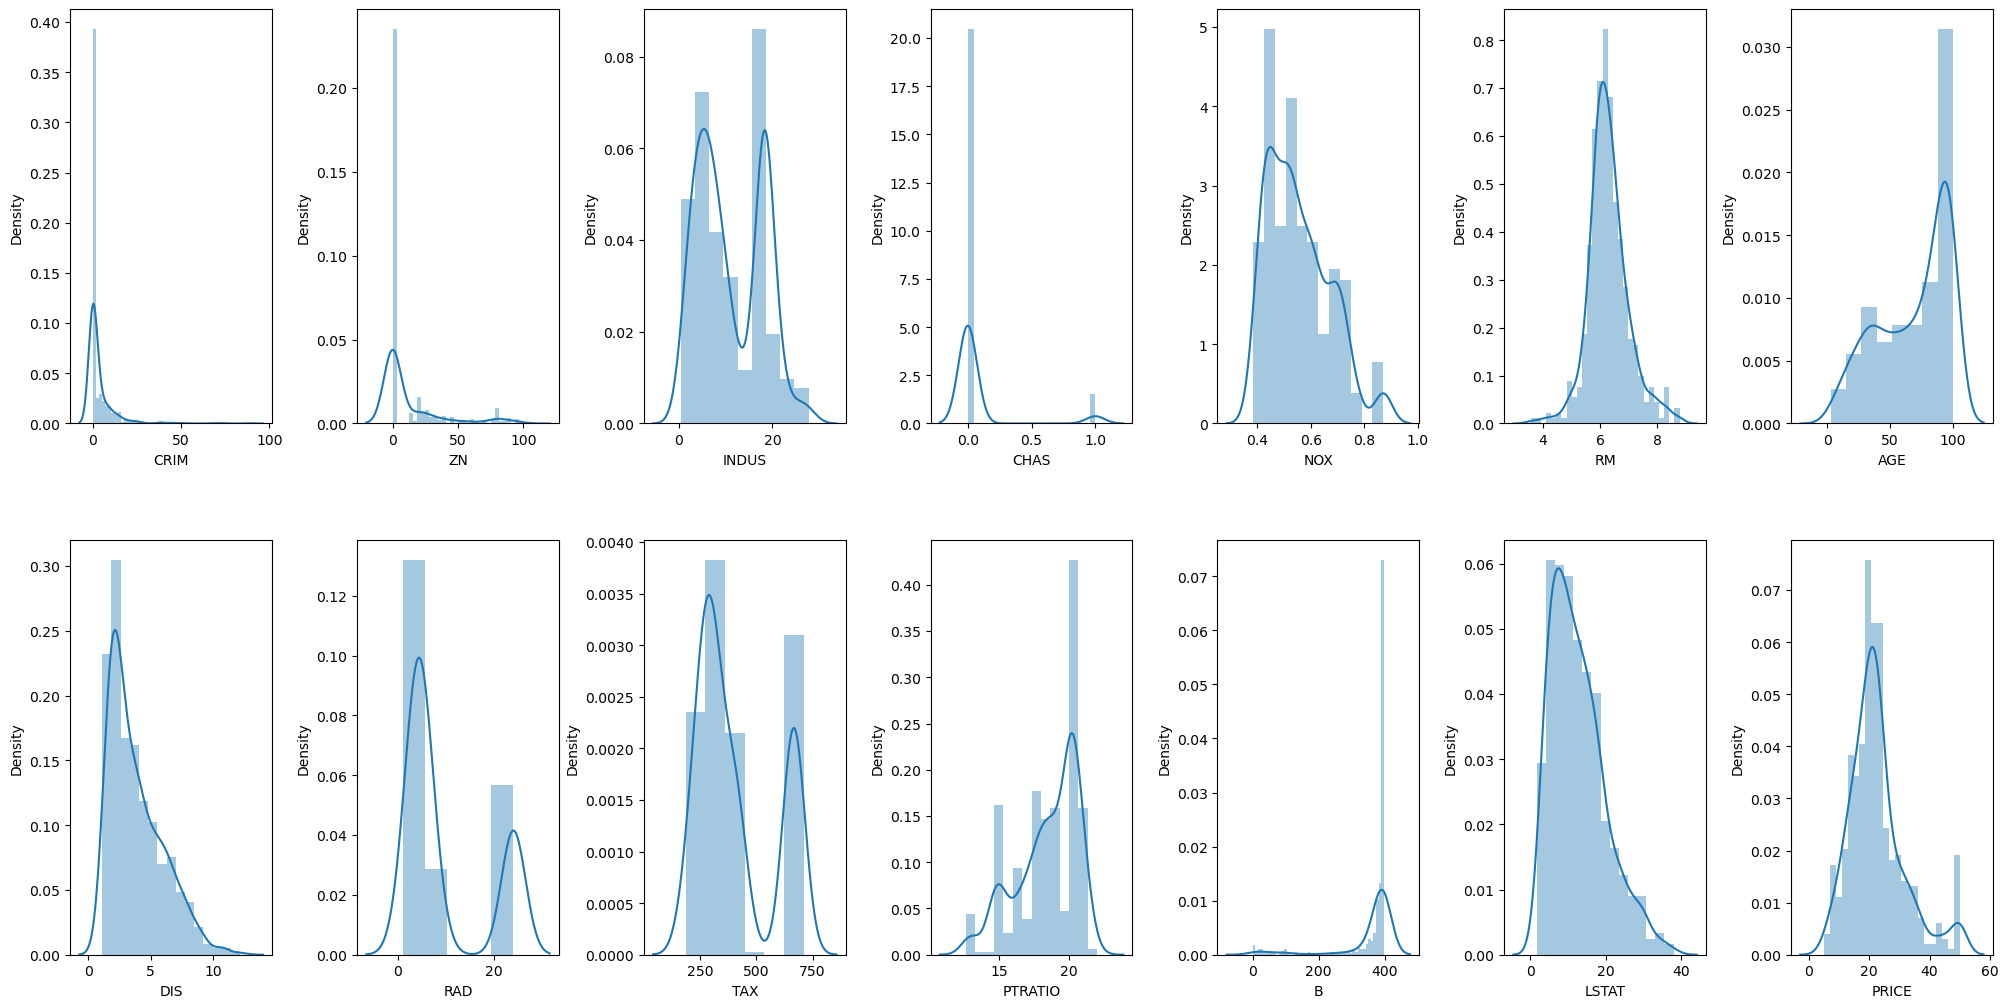

In [22]:
# 모든 데이터의 분포도 확인
fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in df.items():
    sns.distplot(v, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

<AxesSubplot: xlabel='PRICE', ylabel='Density'>

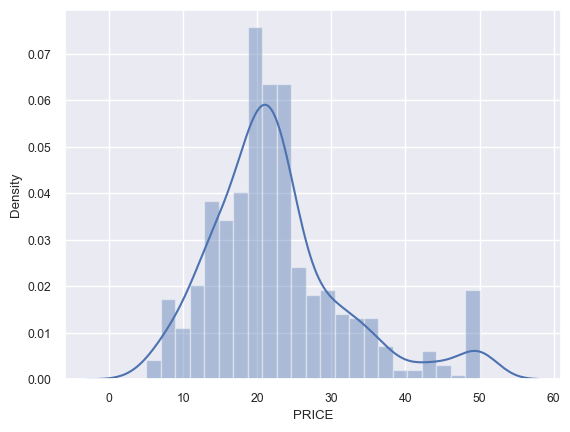

In [30]:
# 집값 데이터 분포
sns.distplot(df['PRICE'])

- 집값이 쏠리는 현상이 발견하면 예측을 하는 것에 있어서 정확한 예측을 하기가 힘들어집니다. 그래서 집값이 쏠려있다면, log나 log1p를 통해 조절해주고는 합니다.

## 회귀분석

- 총 506개의 데이터 -> 30%로 분리

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score

In [33]:
# feature, target 데이터 분리
y = df['PRICE'] # 레이블(종속변수)
X = df.drop(['PRICE'], axis=1, inplace=False) # 피처(독립변수)

# train, test 데이터 분리
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size=0.3, random_state=156)

# Linear Regression
lr = LinearRegression()

# fit 메소드 학습 : 주어진 데이터로 estimator(사이킷런이 제공) 알고리즘 학습
lr.fit(X_train, y_train)

LinearRegression()

In [34]:
print(X_train.shape, X_test.shape)

(354, 13) (152, 13)


In [40]:
# predict 메소드 : 학습된 모델로 예측을 수행
y_preds = lr.predict(X_test)

In [52]:
# 각 좌표당 기울기는 다음과 같습니다
print('절편 값 : ',lr.intercept_)
print('회귀 계수값 : ', np.round(lr.coef_, 1))

절편 값 :  40.9955951721644
회귀 계수값 :  -0.6


In [58]:
# 해당 선형회귀로 세울 수 있는 식
print('선형회귀 식 : ')
for i in range(len(X.columns)):
    print(X.columns[i] +'*'+ str(np.round(lr.coef_[i],2)) + " + ", end='')
print(lr.intercept_)

선형회귀 식 : 
CRIM*-0.11 + ZN*0.07 + INDUS*0.03 + CHAS*3.05 + NOX*-19.8 + RM*3.35 + AGE*0.01 + DIS*-1.74 + RAD*0.36 + TAX*-0.01 + PTRATIO*-0.92 + B*0.01 + LSTAT*-0.57 + 40.9955951721644


CRIM*-0.11 + ZN*0.07 + INDUS*0.03 + CHAS*3.05 + NOX*-19.8 + RM*3.35 + AGE*0.01 + DIS*-1.74 + RAD*0.36 + TAX*-0.01 + PTRATIO*-0.92 + B*0.01 + LSTAT*-0.57 + 40.9955951721644이라는 식이 도출됩니다.

In [ ]:
# 오류 검출 : 이유는?
print(accuracy_score(y_test, y_preds))

- 여기서 수행하는 예측은 저번 타이타닉에서 분류가 아닌, 회귀입니다. 즉, 정답이 정해져 있지 않습니다. 그렇기에, 오차가 얼마나 발생하는지를 정확도로 대신 계산해야 합니다.

- 그를 위해서 저희는 평균 제곱 오차(Mean Squared Error)을 사용합니다.
- 추가적으로 R2 score도 같이 계산하겠습니다.

    - 평균 제곱 오차는 실제값과 예측값의 차이를 제곱해 평균한 것입니다. RMSE는 그러한 평균 제곱 오차에 루트를 씌운 값입니다.
    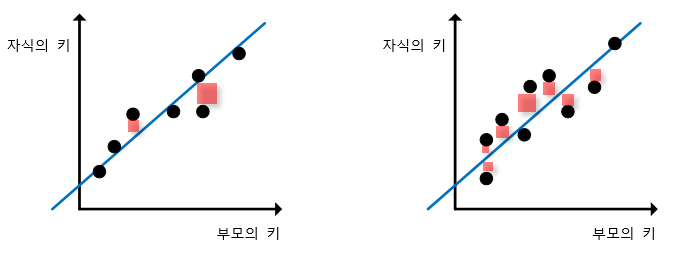
    - R2 score는 실제 값의 분산 대비 예측 값의 분산 비율입니다. 1에 가까울수록 예측 정확도가 높다고 평가할 수 있습니다.
    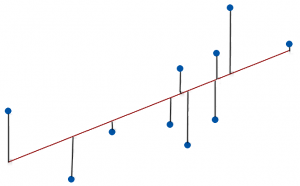

In [41]:
# rmse를 활용한 평가
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)

print(f'MSE : {mse:.3f}, RMSE: {rmse:.3f}')
print(f'Variance score : {r2_score(y_test, y_preds):.3f}')

MSE : 17.297, RMSE: 4.159
Variance score : 0.757


In [42]:
# cross_val_score을 이용한 교차 검증
from sklearn.model_selection import cross_val_score


# 5 folds 의 개별 Negative MSE scores (음수로 만들어 작은 오류 값이 더 큰 숫자로 인식됨)
neg_mse_scores = cross_val_score(lr, X, y, scoring="neg_mean_squared_error", cv = 5)
    # cv는 교차검증의 폴드 수
neg_mse_scores

array([-12.46030057, -26.04862111, -33.07413798, -80.76237112,
       -33.31360656])

In [43]:
# RMSE를 구하기 위해선 MSE 값에 -1을 곱한 후 평균을 내면 된다
rmse_scores =  np.sqrt(-1*neg_mse_scores)
rmse_scores

array([3.52991509, 5.10378498, 5.75101191, 8.9867887 , 5.77179405])

In [44]:
# 5 fold 의 평균 RMSE
avg_rmse = np.mean(rmse_scores)
avg_rmse

5.82865894621583

- 30%를 test로 했더니, 일반적인 선형회귀에서는 rmse가 4.159, 교차검증에서는 5.82가 나온 것을 확인할 수 있습니다. 